# PowerModelsDistribution.jl Transformer Modelling Tutorial

`PowerModelsDistribution.jl` allows modelling power transformers with any number of windings and number of phases taking into account the loss models for each winding. While this is a powerful feature, it can be complex to model and confusing for starting users. Hence, this tutorial is to provide a simple introduction to power transformer models in `PowerModelsDistribution.jl`. For the full details on how the transformer model was implemented please refer to S. Claeys, G. Deconinck and F. Geth, “Decomposition of n-winding transformers for unbalanced optimal power flow,” IET Generation, Transmission & Distribution, vol. 14, no. 24, pp. 5961-5969, 2020, DOI: 10.1049/iet-gtd.2020.0776.


## Transformer Modelling Theory

Starting with the simplest case of a two-winding, single-phase transformer, which will later serve as the fundamental building block for $n$-winding, $n$-phase transformers.

Without delving deeply into the electromagnetic theory of transformer operation, the functioning of a transformer can be simplified as follows: a primary coil (coil 1) and a secondary coil (coil 2) are wound on the same magnetic core. When a voltage $U_1$ is applied to the primary coil, it generates a magnetic flux $\Phi_1$. Part of this flux links the primary coil with itself (not going through the core to the secondary coil), denoted as $\Phi_{11}$, while another part, denoted as $\Phi_{m}$, links the secondary coil. The magnetic flux $\Phi_{m}$ induces a voltage $U_2$ in the secondary coil, which can drive a current $I_2$ when a load is connected to the secondary coil.



Taking into account that each of the coils has a resistance $R_1$ and $R_2$ and modelling the leakage flux $\Phi_{11}$ and $\Phi_{22}$



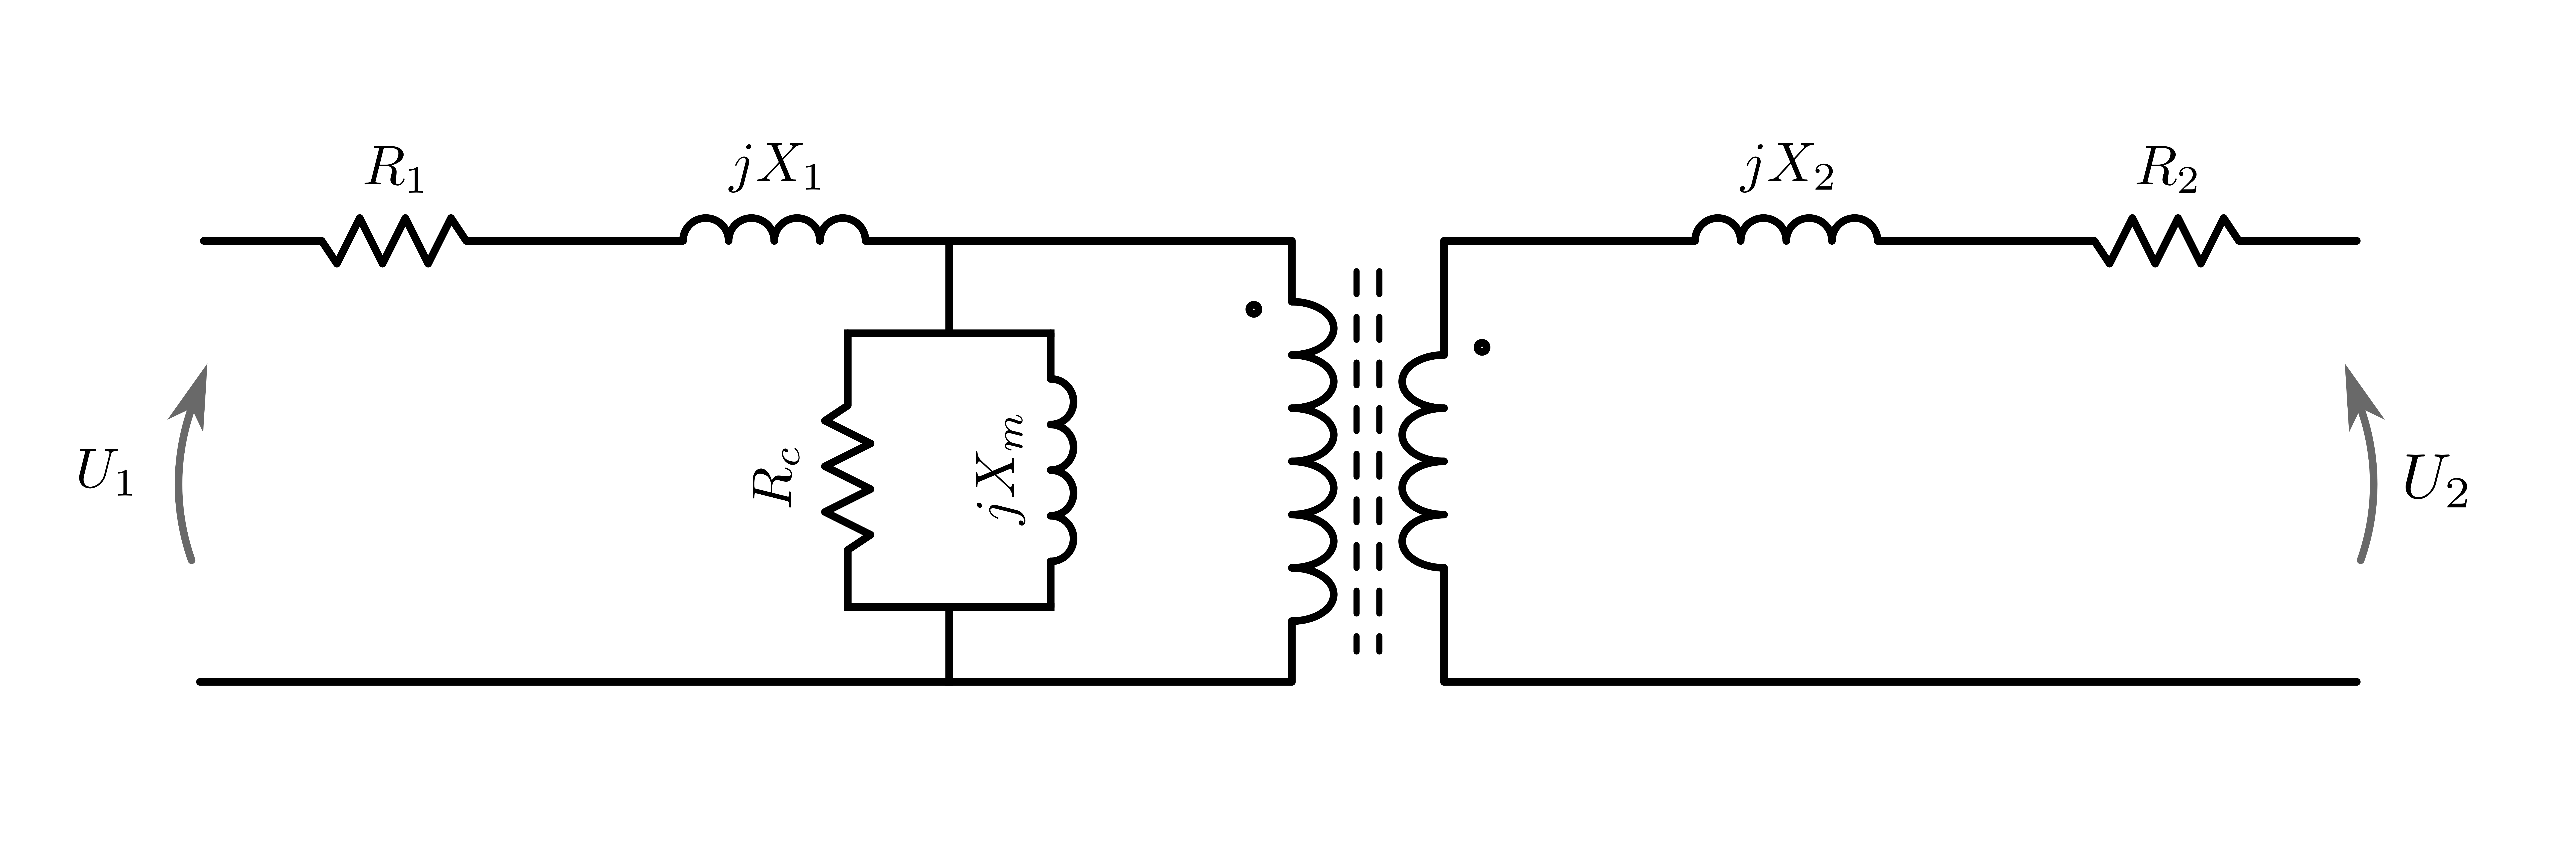



## Limitations of Transformer Modelling in PowerModelsDistribution.jl

When parsing transformer models (e.g. from OpenDSS), there are several important limitations to be aware of:

1.  **Connection Defaults & Vector Groups**: `PowerModelsDistribution.jl` (and its parser) often defaults to specific connections when parsing. It cannot automatically transform every possible connection type from OpenDSS directly. Creating specific vector groups (e.g., Dyn11, Yd11) might require:
    *   Manual modification of the network data structure after parsing using the `PowerModelsDistribution` interface.
    *   Modelling the transformer as single-phase banks in OpenDSS to ensure the correct connection is parsed.

2.  **Neutral Grounding**: The parser might not always infer the neutral grounding correctly from the source file. It is crucial to verify that the neutral is grounded if intended. For example, if a bus has 4 terminals (3 phases + neutral), the 4th terminal must be explicitly set to `grounded = true` if it is a grounded neutral. Failing to do so can lead to a floating neutral which changes the system physics significantly.
3.  **Zigzag transformer not supported Grounding**


In [40]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.add("PowerModelsDistribution")
Pkg.add("Ipopt")

  Activating project at `c:\Users\mnumair\OneDrive - KU Leuven\PhD Agenda\2025\12-25 December\PMD Transformer Model Tutorial`
Precompiling packages...
   3368.3 ms  ? OpenDSSDirect
   Resolving package versions...
     Project No packages added to or removed from `C:\Users\mnumair\OneDrive - KU Leuven\PhD Agenda\2025\12-25 December\PMD Transformer Model Tutorial\Project.toml`
    Manifest No packages added to or removed from `C:\Users\mnumair\OneDrive - KU Leuven\PhD Agenda\2025\12-25 December\PMD Transformer Model Tutorial\Manifest.toml`
Precompiling packages...
   3144.8 ms  ? OpenDSSDirect
   Resolving package versions...
     Project No packages added to or removed from `C:\Users\mnumair\OneDrive - KU Leuven\PhD Agenda\2025\12-25 December\PMD Transformer Model Tutorial\Project.toml`
    Manifest No packages added to or removed from `C:\Users\mnumair\OneDrive - KU Leuven\PhD Agenda\2025\12-25 December\PMD Transformer Model Tutorial\Manifest.toml`
Precompiling packages...
   3179.5 m

In [41]:
Pkg.status()

Status `C:\Users\mnumair\OneDrive - KU Leuven\PhD Agenda\2025\12-25 December\PMD Transformer Model Tutorial\Project.toml`
⌃ [b6b21f68] Ipopt v1.13.0
  [a8b11937] OpenDSSDirect v0.9.9
  [d7431456] PowerModelsDistribution v0.16.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [42]:
using PowerModelsDistribution
using Ipopt

In [43]:
ENV["JULIA_DEBUG"] = "PowerModelsDistribution"


"PowerModelsDistribution"

In [44]:
function show_transformer_math_components(math; suppress_print::Bool=false)
    results = Dict{String, Any}()
    transformer_index_byname = findall(x->haskey(x, "unmap_function") && x["unmap_function"] == "_map_math2eng_transformer!", math["map"])
    for idx in transformer_index_byname
        trafo_name = math["map"][idx]["from"]
        
        if !suppress_print
            printstyled("👇 BEGIN Transformer ",color=:green)
            printstyled(trafo_name,color=:green, bold=true)
            printstyled(" 👇\n",color=:green)        
            display("in the MATHEMATICAL model transformer " * trafo_name*" was converted to: ")
        end
        
        results[trafo_name] = Dict{String, Any}("buses" => Dict{String, Any}(), "branches" => Dict{String, Any}(), "transformers" => Dict{String, Any}())
        
        for element in math["map"][idx]["to"]
            element_type = split(element, ".")[1]
            element_idx = split(element, ".")[2]
            
            if !suppress_print
                display("================================" * element_type * " "* element_idx *"================================")
                # display("Element Index: " * element_idx)    
                display(math[element_type][element_idx])
            end
            
            if element_type == "bus"
                results[trafo_name]["buses"][element_idx] = math[element_type][element_idx]
            elseif element_type == "branch"
                results[trafo_name]["branches"][element_idx] = math[element_type][element_idx]
            elseif element_type == "transformer"
                results[trafo_name]["transformers"][element_idx] = math[element_type][element_idx]
            end
        end
    end
    return results
end

show_transformer_math_components (generic function with 1 method)

In [45]:
pmd_file_path = joinpath(pathof(PowerModelsDistribution), "..\\test\\data")

"C:\\Users\\mnumair\\.julia\\packages\\PowerModelsDistribution\\EOTxp\\src\\PowerModelsDistribution.jl\\..\\test\\data"

## Single-Phase Two-Winding Wye-Wye Transformer

In [46]:
eng_1ph_2w_yy = parse_file("trans_1ph_2w_yy.dss", transformations=[transform_loops!] )

[ PowerModelsDistribution | Info ] : Circuit has been reset with the 'clear' on line 1 in 'trans_1ph_2w_yy.dss'
[ PowerModelsDistribution | Info ] : Command 'batchedit' on line 32 in 'trans_1ph_2w_yy.dss' is not supported, skipping.
[ PowerModelsDistribution | Info ] : Command 'calcvoltagebases' on line 39 in 'trans_1ph_2w_yy.dss' is not supported, skipping.
[ PowerModelsDistribution | Info ] : Command 'solve' on line 42 in 'trans_1ph_2w_yy.dss' is not supported, skipping.
┌ PowerModelsDistribution | Warning ] : basefreq=60.0 on line.line2 does not match circuit basefreq=50.0
└ @ PowerModelsDistribution C:\Users\mnumair\.julia\packages\PowerModelsDistribution\EOTxp\src\data_model\transformations\dss2eng.jl:422
┌ PowerModelsDistribution | Warning ] : basefreq=60.0 on line.line1 does not match circuit basefreq=50.0
└ @ PowerModelsDistribution C:\Users\mnumair\.julia\packages\PowerModelsDistribution\EOTxp\src\data_model\transformations\dss2eng.jl:422


Dict{String, Any} with 11 entries:
  "xfmrcode"       => Dict{String, Any}("tx"=>Dict{String, Any}("sm_ub"=>750.0,…
  "conductor_ids"  => [1, 2, 3, 4]
  "bus"            => Dict{String, Any}("sourcebus"=>Dict{String, Any}("rg"=>[0…
  "name"           => "ut_trans"
  "settings"       => Dict{String, Any}("sbase_default"=>1000.0, "vbases_defaul…
  "files"          => ["trans_1ph_2w_yy.dss"]
  "voltage_source" => Dict{String, Any}("source"=>Dict{String, Any}("source_id"…
  "line"           => Dict{String, Any}("line2"=>Dict{String, Any}("cm_ub"=>[60…
  "data_model"     => ENGINEERING
  "transformer"    => Dict{String, Any}("tx1"=>Dict{String, Any}("polarity"=>[1…
  "load"           => Dict{String, Any}("load1"=>Dict{String, Any}("source_id"=…

In [47]:
eng_1ph_2w_yy["transformer"]["tx1"]["vm_nom"][1] /eng_1ph_2w_yy["transformer"]["tx1"]["vm_nom"][2]

27.5

In [48]:
math_1ph_2w_yy = transform_data_model(eng_1ph_2w_yy)

Dict{String, Any} with 18 entries:
  "is_kron_reduced" => true
  "conductor_ids"   => [1, 2, 3]
  "time_elapsed"    => 1.0
  "bus"             => Dict{String, Any}("8"=>Dict{String, Any}("vm_pair_lb"=>T…
  "name"            => "ut_trans"
  "map"             => Dict{String, Any}[Dict("unmap_function"=>"_map_math2eng_…
  "settings"        => Dict{String, Any}("sbase_default"=>1000.0, "vbases_defau…
  "gen"             => Dict{String, Any}("1"=>Dict{String, Any}("pg"=>[0.0, 0.0…
  "branch"          => Dict{String, Any}("4"=>Dict{String, Any}("br_r"=>[0.0;;]…
  "storage"         => Dict{String, Any}()
  "switch"          => Dict{String, Any}()
  "is_projected"    => true
  "per_unit"        => true
  "data_model"      => MATHEMATICAL
  "shunt"           => Dict{String, Any}()
  "transformer"     => Dict{String, Any}("1"=>Dict{String, Any}("source_id"=>"_…
  "bus_lookup"      => Dict{Any, Int64}("sourcebus"=>1, "1"=>2, "2"=>3, "3"=>4)
  "load"            => Dict{String, Any}("1"=>Dict{Strin

In [49]:
show_transformer_math_components(math_1ph_2w_yy) # you can reuse this function for any of the next models to see how the transformer was mapped in the MATHEMATICAL model

👇 BEGIN Transformer tx1 👇


"in the MATHEMATICAL model transformer tx1 was converted to: "

"================================bus 5================================"

Dict{String, Any} with 13 entries:
  "vm_pair_lb" => Tuple{Any, Any, Real}[]
  "source_id"  => "transformer.tx1"
  "grounded"   => Bool[0]
  "vmin"       => [0.0]
  "vm_pair_ub" => Tuple{Any, Any, Real}[]
  "bus_i"      => 5
  "index"      => 5
  "name"       => "_virtual_bus.transformer.tx1_4"
  "bus_type"   => 1
  "terminals"  => [1]
  "vmax"       => [Inf]
  "base_kv"    => 1.0
  "vbase"      => 0.57735

"================================bus 6================================"

Dict{String, Any} with 13 entries:
  "vm_pair_lb" => Tuple{Any, Any, Real}[]
  "source_id"  => "transformer.tx1"
  "grounded"   => Bool[0]
  "vmin"       => [0.0]
  "vm_pair_ub" => Tuple{Any, Any, Real}[]
  "bus_i"      => 6
  "index"      => 6
  "name"       => "_virtual_bus.transformer.tx1_2"
  "bus_type"   => 1
  "terminals"  => [1]
  "vmax"       => [Inf]
  "base_kv"    => 1.0
  "vbase"      => 0.57735

"================================bus 7================================"

Dict{String, Any} with 13 entries:
  "vm_pair_lb" => Tuple{Any, Any, Real}[]
  "source_id"  => "transformer.tx1"
  "grounded"   => Bool[0]
  "vmin"       => [0.0]
  "vm_pair_ub" => Tuple{Any, Any, Real}[]
  "bus_i"      => 7
  "index"      => 7
  "name"       => "_virtual_bus.transformer.tx1_3"
  "bus_type"   => 1
  "terminals"  => [1]
  "vmax"       => [Inf]
  "base_kv"    => 1.0
  "vbase"      => 0.57735

"================================bus 8================================"

Dict{String, Any} with 13 entries:
  "vm_pair_lb" => Tuple{Any, Any, Real}[]
  "source_id"  => "transformer.tx1"
  "grounded"   => Bool[0]
  "vmin"       => [0.0]
  "vm_pair_ub" => Tuple{Any, Any, Real}[]
  "bus_i"      => 8
  "index"      => 8
  "name"       => "_virtual_bus.transformer.tx1_1"
  "bus_type"   => 1
  "terminals"  => [1]
  "vmax"       => [Inf]
  "base_kv"    => 1.0
  "vbase"      => 0.57735

"================================branch 3================================"

Dict{String, Any} with 22 entries:
  "br_r"          => [0.12;;]
  "br_x"          => [0.0;;]
  "g_to"          => [0.0;;]
  "c_rating_a"    => [Inf]
  "vbase"         => 0.57735
  "source_id"     => "_virtual_branch.transformer.tx1_2"
  "br_status"     => 1
  "b_to"          => [0.0;;]
  "index"         => 3
  "tap"           => [1.0]
  "shift"         => [0.0]
  "f_connections" => [1]
  "name"          => "_virtual_branch.transformer.tx1_2"
  "switch"        => false
  "g_fr"          => [0.00833333;;]
  "b_fr"          => [-0.0183333;;]
  "t_connections" => [1]
  "f_bus"         => 6
  "t_bus"         => 5
  ⋮               => ⋮

"================================branch 4================================"

Dict{String, Any} with 22 entries:
  "br_r"          => [0.0;;]
  "br_x"          => [0.3;;]
  "g_to"          => [0.0;;]
  "c_rating_a"    => [Inf]
  "vbase"         => 0.57735
  "source_id"     => "_virtual_branch.transformer.tx1_3"
  "br_status"     => 1
  "b_to"          => [0.0;;]
  "index"         => 4
  "tap"           => [1.0]
  "shift"         => [0.0]
  "f_connections" => [1]
  "name"          => "_virtual_branch.transformer.tx1_3"
  "switch"        => false
  "g_fr"          => [0.0;;]
  "b_fr"          => [0.0;;]
  "t_connections" => [1]
  "f_bus"         => 7
  "t_bus"         => 5
  ⋮               => ⋮

"================================branch 5================================"

Dict{String, Any} with 22 entries:
  "br_r"          => [0.06;;]
  "br_x"          => [0.0;;]
  "g_to"          => [0.0;;]
  "c_rating_a"    => [Inf]
  "vbase"         => 0.57735
  "source_id"     => "_virtual_branch.transformer.tx1_1"
  "br_status"     => 1
  "b_to"          => [0.0;;]
  "index"         => 5
  "tap"           => [1.0]
  "shift"         => [0.0]
  "f_connections" => [1]
  "name"          => "_virtual_branch.transformer.tx1_1"
  "switch"        => false
  "g_fr"          => [0.0;;]
  "b_fr"          => [0.0;;]
  "t_connections" => [1]
  "f_bus"         => 8
  "t_bus"         => 7
  ⋮               => ⋮

"================================transformer 1================================"

Dict{String, Any} with 20 entries:
  "source_id"     => "_virtual_transformer.transformer.tx1.1"
  "t_connections" => [1]
  "f_bus"         => 2
  "polarity"      => 1
  "sm_ub"         => 0.75
  "cm_ub"         => Inf
  "tm_fix"        => Bool[1]
  "tm_lb"         => [0.9]
  "tm_set"        => [1.05]
  "t_vbase"       => 0.57735
  "tm_step"       => [0.03125]
  "t_bus"         => 8
  "f_connections" => [1]
  "configuration" => WYE
  "index"         => 1
  "name"          => "_virtual_transformer.tx1.1"
  "tm_nom"        => 1.0
  "status"        => 1
  "tm_ub"         => [1.1]
  "f_vbase"       => 6.35085

"================================transformer 2================================"

Dict{String, Any} with 20 entries:
  "source_id"     => "_virtual_transformer.transformer.tx1.2"
  "t_connections" => [1]
  "f_bus"         => 3
  "polarity"      => 1
  "sm_ub"         => 0.75
  "cm_ub"         => Inf
  "tm_fix"        => Bool[1]
  "tm_lb"         => [0.9]
  "tm_set"        => [0.95]
  "t_vbase"       => 0.57735
  "tm_step"       => [0.03125]
  "t_bus"         => 6
  "f_connections" => [1]
  "configuration" => WYE
  "index"         => 2
  "name"          => "_virtual_transformer.tx1.2"
  "tm_nom"        => 1.0
  "status"        => 1
  "tm_ub"         => [1.1]
  "f_vbase"       => 0.23094

Dict{String, Any} with 1 entry:
  "tx1" => Dict{String, Any}("branches"=>Dict{String, Any}("4"=>Dict{String, An…

In [50]:
(math_1ph_2w_yy["transformer"]["1"]["f_vbase"]/math_1ph_2w_yy["transformer"]["1"]["t_vbase"]) * (math_1ph_2w_yy["transformer"]["2"]["t_vbase"]/math_1ph_2w_yy["transformer"]["2"]["f_vbase"])

27.499999999999996

To get the ratio for the whole transformer - you divide the `f_vbase` of the first ideal transformer by the `f_vbase` of the second ideal transformer. (this will match the ratio of the real transformers)

In [51]:
math_1ph_2w_yy["transformer"]["1"]["f_vbase"]/math_1ph_2w_yy["transformer"]["2"]["f_vbase"]

27.499999999999993

Summary Notes on 1-Ph Wye-Wye


We are looking at the LN to LN voltage ratio being 6.35/2.3094 (which was defined in OpenDSS LL voltages 11/4)


In `PowerModelsDistribution.jl` this transformer is split into two ideal transformer one step down 6.35 (`f_vbase`) to 0.57735 (`t_vbase`) and another step up 0.57735 (`t_vbase`) to 2.3094 (`f_vbase`)
NOTE: the arbitrary virtual loss model voltage (0.57735) is alway on the to `t_` side of the transformer meaning that the second transformer is flipped kind of 

## Three-Phase Two-Winding Wye-Wye Transformer

In [52]:
eng_3ph_2w_yy = parse_file(joinpath(dirname(pathof(PowerModelsDistribution)), "..\\test\\data\\opendss\\ut_trans_2w_yy.dss"), transformations=[transform_loops!] )

[ PowerModelsDistribution | Info ] : Circuit has been reset with the 'clear' on line 1 in 'ut_trans_2w_yy.dss'
[ PowerModelsDistribution | Info ] : Command 'calcvoltagebases' on line 35 in 'ut_trans_2w_yy.dss' is not supported, skipping.
[ PowerModelsDistribution | Info ] : Command 'solve' on line 38 in 'ut_trans_2w_yy.dss' is not supported, skipping.


Dict{String, Any} with 10 entries:
  "voltage_source" => Dict{String, Any}("source"=>Dict{String, Any}("source_id"…
  "name"           => "ut_trans"
  "line"           => Dict{String, Any}("line2"=>Dict{String, Any}("cm_ub"=>[60…
  "conductor_ids"  => [1, 2, 3, 4]
  "settings"       => Dict{String, Any}("sbase_default"=>1.0, "vbases_default"=…
  "files"          => ["C:\\Users\\mnumair\\.julia\\packages\\PowerModelsDistri…
  "transformer"    => Dict{String, Any}("tx1"=>Dict{String, Any}("polarity"=>[1…
  "load"           => Dict{String, Any}("load3"=>Dict{String, Any}("source_id"=…
  "bus"            => Dict{String, Any}("1"=>Dict{String, Any}("rg"=>[0.0], "gr…
  "data_model"     => ENGINEERING

In [53]:
math_3ph_2w_yy = transform_data_model(eng_3ph_2w_yy)

Dict{String, Any} with 18 entries:
  "is_kron_reduced" => true
  "conductor_ids"   => [1, 2, 3]
  "time_elapsed"    => 1.0
  "bus"             => Dict{String, Any}("8"=>Dict{String, Any}("vm_pair_lb"=>T…
  "name"            => "ut_trans"
  "map"             => Dict{String, Any}[Dict("unmap_function"=>"_map_math2eng_…
  "settings"        => Dict{String, Any}("sbase_default"=>1.0, "vbases_default"…
  "gen"             => Dict{String, Any}("1"=>Dict{String, Any}("pg"=>[0.0, 0.0…
  "branch"          => Dict{String, Any}("4"=>Dict{String, Any}("br_r"=>[0.0 0.…
  "storage"         => Dict{String, Any}()
  "switch"          => Dict{String, Any}()
  "is_projected"    => true
  "per_unit"        => true
  "data_model"      => MATHEMATICAL
  "shunt"           => Dict{String, Any}()
  "transformer"     => Dict{String, Any}("1"=>Dict{String, Any}("source_id"=>"_…
  "bus_lookup"      => Dict{Any, Int64}("1"=>1, "sourcebus"=>2, "2"=>3, "3"=>4)
  "load"            => Dict{String, Any}("4"=>Dict{Strin

In [54]:
tx_mapping = show_transformer_math_components(math_1ph_2w_yy, suppress_print=true) 

Dict{String, Any} with 1 entry:
  "tx1" => Dict{String, Any}("branches"=>Dict{String, Any}("4"=>Dict{String, An…

## Three-Phase Explicit Neutral Two-Winding Wye-Wye Transformer

In [55]:
eng_3ph_en_2w_yy = parse_file(joinpath(dirname(pathof(PowerModelsDistribution)), "..\\test\\data\\en_validation_case_data\\test_trans_yy.dss"), transformations=[transform_loops!] )

[ PowerModelsDistribution | Info ] : Circuit has been reset with the 'clear' on line 3 in 'test_trans_yy.dss'
[ PowerModelsDistribution | Info ] : Command 'calcvoltagebases' on line 36 in 'test_trans_yy.dss' is not supported, skipping.
[ PowerModelsDistribution | Info ] : Command 'solve' on line 38 in 'test_trans_yy.dss' is not supported, skipping.
┌ PowerModelsDistribution | Warning ] : reactors as constant impedance elements is not yet supported, treating reactor.grounding like line
└ @ PowerModelsDistribution C:\Users\mnumair\.julia\packages\PowerModelsDistribution\EOTxp\src\data_model\transformations\dss2eng.jl:263


Dict{String, Any} with 12 entries:
  "conductor_ids"  => [1, 2, 3, 4, 5]
  "bus"            => Dict{String, Any}("x1"=>Dict{String, Any}("rg"=>[0.0], "g…
  "name"           => "test"
  "settings"       => Dict{String, Any}("sbase_default"=>200.0, "vbases_default…
  "files"          => ["C:\\Users\\mnumair\\.julia\\packages\\PowerModelsDistri…
  "voltage_source" => Dict{String, Any}("source"=>Dict{String, Any}("source_id"…
  "line"           => Dict{String, Any}("line2"=>Dict{String, Any}("length"=>50…
  "data_model"     => ENGINEERING
  "transformer"    => Dict{String, Any}("transformer1"=>Dict{String, Any}("pola…
  "shunt"          => Dict{String, Any}("line_loop.grounding"=>Dict{String, Any…
  "load"           => Dict{String, Any}("load1"=>Dict{String, Any}("source_id"=…
  "linecode"       => Dict{String, Any}("zabcn"=>Dict{String, Any}("b_fr"=>[0.0…

In [56]:
math_3ph_en_2w_yy = transform_data_model(eng_3ph_en_2w_yy, kron_reduce = false, phase_project = false)

Dict{String, Any} with 18 entries:
  "is_kron_reduced" => false
  "conductor_ids"   => [1, 2, 3, 4, 5]
  "time_elapsed"    => 1.0
  "bus"             => Dict{String, Any}("8"=>Dict{String, Any}("vm_pair_lb"=>T…
  "name"            => "test"
  "map"             => Dict{String, Any}[Dict("unmap_function"=>"_map_math2eng_…
  "settings"        => Dict{String, Any}("sbase_default"=>200.0, "vbases_defaul…
  "gen"             => Dict{String, Any}("1"=>Dict{String, Any}("pg"=>[0.0, 0.0…
  "branch"          => Dict{String, Any}("4"=>Dict{String, Any}("br_r"=>[0.0 0.…
  "storage"         => Dict{String, Any}()
  "switch"          => Dict{String, Any}()
  "is_projected"    => false
  "per_unit"        => true
  "data_model"      => MATHEMATICAL
  "shunt"           => Dict{String, Any}("1"=>Dict{String, Any}("source_id"=>"s…
  "transformer"     => Dict{String, Any}("1"=>Dict{String, Any}("source_id"=>"_…
  "bus_lookup"      => Dict{Any, Int64}("x1"=>1, "x2"=>2, "b2"=>3, "b1"=>4)
  "load"          

## Three-Phase Two-Winding Delta-Wye (lead) Transformer

In [57]:
eng_3ph_2w_dy = parse_file(joinpath(dirname(pathof(PowerModelsDistribution)), "..\\test\\data\\opendss\\ut_trans_2w_dy_lead.dss"), transformations=[transform_loops!] )

[ PowerModelsDistribution | Info ] : Circuit has been reset with the 'clear' on line 1 in 'ut_trans_2w_dy_lead.dss'
[ PowerModelsDistribution | Info ] : Command 'calcvoltagebases' on line 36 in 'ut_trans_2w_dy_lead.dss' is not supported, skipping.
[ PowerModelsDistribution | Info ] : Command 'solve' on line 39 in 'ut_trans_2w_dy_lead.dss' is not supported, skipping.


Dict{String, Any} with 10 entries:
  "voltage_source" => Dict{String, Any}("source"=>Dict{String, Any}("source_id"…
  "name"           => "ut_trans"
  "line"           => Dict{String, Any}("line2"=>Dict{String, Any}("cm_ub"=>[60…
  "conductor_ids"  => [1, 2, 3, 4]
  "settings"       => Dict{String, Any}("sbase_default"=>100.0, "vbases_default…
  "files"          => ["C:\\Users\\mnumair\\.julia\\packages\\PowerModelsDistri…
  "transformer"    => Dict{String, Any}("tx1"=>Dict{String, Any}("polarity"=>[1…
  "load"           => Dict{String, Any}("load3"=>Dict{String, Any}("source_id"=…
  "bus"            => Dict{String, Any}("1"=>Dict{String, Any}("rg"=>[0.0], "gr…
  "data_model"     => ENGINEERING

In [58]:
math_3ph_2w_dy = transform_data_model(eng_3ph_2w_dy)

Dict{String, Any} with 18 entries:
  "is_kron_reduced" => true
  "conductor_ids"   => [1, 2, 3]
  "time_elapsed"    => 1.0
  "bus"             => Dict{String, Any}("8"=>Dict{String, Any}("vm_pair_lb"=>T…
  "name"            => "ut_trans"
  "map"             => Dict{String, Any}[Dict("unmap_function"=>"_map_math2eng_…
  "settings"        => Dict{String, Any}("sbase_default"=>100.0, "vbases_defaul…
  "gen"             => Dict{String, Any}("1"=>Dict{String, Any}("pg"=>[0.0, 0.0…
  "branch"          => Dict{String, Any}("4"=>Dict{String, Any}("br_r"=>[0.0 0.…
  "storage"         => Dict{String, Any}()
  "switch"          => Dict{String, Any}()
  "is_projected"    => true
  "per_unit"        => true
  "data_model"      => MATHEMATICAL
  "shunt"           => Dict{String, Any}()
  "transformer"     => Dict{String, Any}("1"=>Dict{String, Any}("source_id"=>"_…
  "bus_lookup"      => Dict{Any, Int64}("1"=>1, "sourcebus"=>2, "2"=>3, "3"=>4)
  "load"            => Dict{String, Any}("4"=>Dict{Strin

## Three-Phase Explicit Neutral Two-Winding Delta-Wye (lag) Transformer   

In [59]:
eng_3ph_en_2w_dy = parse_file(joinpath(dirname(pathof(PowerModelsDistribution)), "..\\test\\data\\en_validation_case_data\\test_trans_dy.dss"), transformations=[transform_loops!] )


[ PowerModelsDistribution | Info ] : Circuit has been reset with the 'clear' on line 3 in 'test_trans_dy.dss'
[ PowerModelsDistribution | Info ] : Command 'calcvoltagebases' on line 36 in 'test_trans_dy.dss' is not supported, skipping.
[ PowerModelsDistribution | Info ] : Command 'solve' on line 38 in 'test_trans_dy.dss' is not supported, skipping.
┌ PowerModelsDistribution | Warning ] : reactors as constant impedance elements is not yet supported, treating reactor.grounding like line
└ @ PowerModelsDistribution C:\Users\mnumair\.julia\packages\PowerModelsDistribution\EOTxp\src\data_model\transformations\dss2eng.jl:263


Dict{String, Any} with 12 entries:
  "conductor_ids"  => [1, 2, 3, 4, 5]
  "bus"            => Dict{String, Any}("x1"=>Dict{String, Any}("rg"=>Float64[]…
  "name"           => "test"
  "settings"       => Dict{String, Any}("sbase_default"=>200.0, "vbases_default…
  "files"          => ["C:\\Users\\mnumair\\.julia\\packages\\PowerModelsDistri…
  "voltage_source" => Dict{String, Any}("source"=>Dict{String, Any}("source_id"…
  "line"           => Dict{String, Any}("line2"=>Dict{String, Any}("length"=>50…
  "data_model"     => ENGINEERING
  "transformer"    => Dict{String, Any}("transformer1"=>Dict{String, Any}("pola…
  "shunt"          => Dict{String, Any}("line_loop.grounding"=>Dict{String, Any…
  "load"           => Dict{String, Any}("load1"=>Dict{String, Any}("source_id"=…
  "linecode"       => Dict{String, Any}("zabcn"=>Dict{String, Any}("b_fr"=>[0.0…

In [60]:
math_3ph_en_2w_dy = transform_data_model(eng_3ph_en_2w_dy, kron_reduce = false, phase_project=false)

Dict{String, Any} with 18 entries:
  "is_kron_reduced" => false
  "conductor_ids"   => [1, 2, 3, 4, 5]
  "time_elapsed"    => 1.0
  "bus"             => Dict{String, Any}("8"=>Dict{String, Any}("vm_pair_lb"=>T…
  "name"            => "test"
  "map"             => Dict{String, Any}[Dict("unmap_function"=>"_map_math2eng_…
  "settings"        => Dict{String, Any}("sbase_default"=>200.0, "vbases_defaul…
  "gen"             => Dict{String, Any}("1"=>Dict{String, Any}("pg"=>[0.0, 0.0…
  "branch"          => Dict{String, Any}("4"=>Dict{String, Any}("br_r"=>[0.0 0.…
  "storage"         => Dict{String, Any}()
  "switch"          => Dict{String, Any}()
  "is_projected"    => false
  "per_unit"        => true
  "data_model"      => MATHEMATICAL
  "shunt"           => Dict{String, Any}("1"=>Dict{String, Any}("source_id"=>"s…
  "transformer"     => Dict{String, Any}("1"=>Dict{String, Any}("source_id"=>"_…
  "bus_lookup"      => Dict{Any, Int64}("x1"=>1, "x2"=>2, "b2"=>3, "b1"=>4)
  "load"          

In [61]:
show_transformer_math_components(math_3ph_en_2w_dy, suppress_print=false) 

"in the MATHEMATICAL model transformer transformer1 was converted to: "

"================================bus 5================================"

Dict{String, Any} with 13 entries:
  "vm_pair_lb" => Tuple{Any, Any, Real}[]
  "source_id"  => "transformer.transformer1"
  "grounded"   => Bool[0, 0, 0]
  "vmin"       => [0.0, 0.0, 0.0]
  "vm_pair_ub" => Tuple{Any, Any, Real}[]
  "bus_i"      => 5
  "index"      => 5
  "name"       => "_virtual_bus.transformer.transformer1_4"
  "bus_type"   => 1
  "terminals"  => [1, 2, 3]
  "vmax"       => [Inf, Inf, Inf]
  "base_kv"    => 1.0
  "vbase"      => 0.57735

"================================bus 6================================"

Dict{String, Any} with 15 entries:
  "vm_pair_lb" => Tuple{Any, Any, Real}[]
  "source_id"  => "transformer.transformer1"
  "grounded"   => Bool[0, 0, 0, 1]
  "vmin"       => [0.0, 0.0, 0.0, 0.0]
  "vm_pair_ub" => Tuple{Any, Any, Real}[]
  "bus_i"      => 6
  "index"      => 6
  "name"       => "_virtual_bus.transformer.transformer1_2"
  "bus_type"   => 1
  "rg"         => [0.0]
  "terminals"  => [1, 2, 3, 4]
  "vmax"       => [Inf, Inf, Inf, Inf]
  "base_kv"    => 1.0
  "xg"         => [0.0]
  "vbase"      => 0.57735

"================================bus 7================================"

Dict{String, Any} with 13 entries:
  "vm_pair_lb" => Tuple{Any, Any, Real}[]
  "source_id"  => "transformer.transformer1"
  "grounded"   => Bool[0, 0, 0]
  "vmin"       => [0.0, 0.0, 0.0]
  "vm_pair_ub" => Tuple{Any, Any, Real}[]
  "bus_i"      => 7
  "index"      => 7
  "name"       => "_virtual_bus.transformer.transformer1_3"
  "bus_type"   => 1
  "terminals"  => [1, 2, 3]
  "vmax"       => [Inf, Inf, Inf]
  "base_kv"    => 1.0
  "vbase"      => 0.57735

"================================bus 8================================"

Dict{String, Any} with 15 entries:
  "vm_pair_lb" => Tuple{Any, Any, Real}[]
  "source_id"  => "transformer.transformer1"
  "grounded"   => Bool[0, 0, 0, 1]
  "vmin"       => [0.0, 0.0, 0.0, 0.0]
  "vm_pair_ub" => Tuple{Any, Any, Real}[]
  "bus_i"      => 8
  "index"      => 8
  "name"       => "_virtual_bus.transformer.transformer1_1"
  "bus_type"   => 1
  "rg"         => [0.0]
  "terminals"  => [1, 2, 3, 4]
  "vmax"       => [Inf, Inf, Inf, Inf]
  "base_kv"    => 1.0
  "xg"         => [0.0]
  "vbase"      => 0.57735

"================================branch 3================================"

Dict{String, Any} with 22 entries:
  "br_r"          => [0.024 0.0 0.0; 0.0 0.024 0.0; 0.0 0.0 0.024]
  "br_x"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "g_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "c_rating_a"    => [Inf, Inf, Inf]
  "vbase"         => 0.57735
  "source_id"     => "_virtual_branch.transformer.transformer1_2"
  "br_status"     => 1
  "b_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "index"         => 3
  "tap"           => [1.0, 1.0, 1.0]
  "shift"         => [0.0, 0.0, 0.0]
  "f_connections" => [1, 2, 3]
  "name"          => "_virtual_branch.transformer.transformer1_2"
  "switch"        => false
  "g_fr"          => [0.0416667 0.0 0.0; 0.0 0.0416667 0.0; 0.0 0.0 0.0416667]
  "b_fr"          => [-0.0916667 0.0 0.0; 0.0 -0.0916667 0.0; 0.0 0.0 -0.091666…
  "t_connections" => [1, 2, 3]
  "f_bus"         => 6
  "t_bus"         => 5
  ⋮               => ⋮

"================================branch 4================================"

Dict{String, Any} with 22 entries:
  "br_r"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "br_x"          => [0.06 0.0 0.0; 0.0 0.06 0.0; 0.0 0.0 0.06]
  "g_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "c_rating_a"    => [Inf, Inf, Inf]
  "vbase"         => 0.57735
  "source_id"     => "_virtual_branch.transformer.transformer1_3"
  "br_status"     => 1
  "b_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "index"         => 4
  "tap"           => [1.0, 1.0, 1.0]
  "shift"         => [0.0, 0.0, 0.0]
  "f_connections" => [1, 2, 3]
  "name"          => "_virtual_branch.transformer.transformer1_3"
  "switch"        => false
  "g_fr"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "b_fr"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "t_connections" => [1, 2, 3]
  "f_bus"         => 7
  "t_bus"         => 5
  ⋮               => ⋮

"================================branch 5================================"

Dict{String, Any} with 22 entries:
  "br_r"          => [0.012 0.0 0.0; 0.0 0.012 0.0; 0.0 0.0 0.012]
  "br_x"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "g_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "c_rating_a"    => [Inf, Inf, Inf]
  "vbase"         => 0.57735
  "source_id"     => "_virtual_branch.transformer.transformer1_1"
  "br_status"     => 1
  "b_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "index"         => 5
  "tap"           => [1.0, 1.0, 1.0]
  "shift"         => [0.0, 0.0, 0.0]
  "f_connections" => [1, 2, 3]
  "name"          => "_virtual_branch.transformer.transformer1_1"
  "switch"        => false
  "g_fr"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "b_fr"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "t_connections" => [1, 2, 3]
  "f_bus"         => 8
  "t_bus"         => 7
  ⋮               => ⋮

"================================transformer 1================================"

Dict{String, Any} with 20 entries:
  "source_id"     => "_virtual_transformer.transformer.transformer1.1"
  "t_connections" => [1, 2, 3, 4]
  "f_bus"         => 1
  "polarity"      => 1
  "sm_ub"         => 3.75
  "cm_ub"         => Inf
  "tm_fix"        => Bool[1, 1, 1]
  "tm_lb"         => [0.9, 0.9, 0.9]
  "tm_set"        => [1.02, 1.02, 1.02]
  "t_vbase"       => 0.57735
  "tm_step"       => [0.03125, 0.03125, 0.03125]
  "t_bus"         => 8
  "f_connections" => [1, 2, 3]
  "configuration" => DELTA
  "index"         => 1
  "name"          => "_virtual_transformer.transformer1.1"
  "tm_nom"        => 1.73205
  "status"        => 1
  "tm_ub"         => [1.1, 1.1, 1.1]
  "f_vbase"       => 6.35085

"================================transformer 2================================"

Dict{String, Any} with 20 entries:
  "source_id"     => "_virtual_transformer.transformer.transformer1.2"
  "t_connections" => [1, 2, 3, 4]
  "f_bus"         => 2
  "polarity"      => -1
  "sm_ub"         => 3.75
  "cm_ub"         => Inf
  "tm_fix"        => Bool[1, 1, 1]
  "tm_lb"         => [0.9, 0.9, 0.9]
  "tm_set"        => [0.97, 0.97, 0.97]
  "t_vbase"       => 0.57735
  "tm_step"       => [0.03125, 0.03125, 0.03125]
  "t_bus"         => 6
  "f_connections" => [1, 3, 2, 5]
  "configuration" => WYE
  "index"         => 2
  "name"          => "_virtual_transformer.transformer1.2"
  "tm_nom"        => 1.0
  "status"        => 1
  "tm_ub"         => [1.1, 1.1, 1.1]
  "f_vbase"       => 0.23094

👇 BEGIN Transformer transformer1 👇


Dict{String, Any} with 1 entry:
  "transformer1" => Dict{String, Any}("branches"=>Dict{String, Any}("4"=>Dict{S…

# Transformer Vector Groups

In three-phase power systems, transformers can connect the primary and secondary windings in different configurations (Wye, Delta, Zigzag, etc.). The combination of connection types and the resulting phase shift between the high-voltage (HV) and low-voltage (LV) sides is described by the **Vector Group**.

The vector group is usually denoted by a code such as **Dyn11**:
*   **D**: Capital letter indicates the High Voltage (HV) winding connection (D = Delta, Y = Wye/Star, Z = Zigzag).
*   **y**: Lowercase letter indicates the Low Voltage (LV) winding connection (d = Delta, y = Wye/Star, z = Zigzag).
*   **n**: Indicates if the Neutral is brought out (accessible).
*   **11**: The "Clock Number" representing the phase shift.

## Clock Notation
The phase shift is measured in units of 30 degrees (like the hours on a clock). The HV phasor is taken as the reference at 12 o'clock (0°).
*   **1**: LV phasor at 1 o'clock (-30° lag).
*   **11**: LV phasor at 11 o'clock (+30° lead).
*   **0**: LV phasor in phase with HV (0°).
*   **6**: LV phasor in anti-phase (180°).

## Common Vector Groups and Phase Shifts

| Vector Group | HV Con. | LV Con. | Phase Shift (LV vs HV) |
| :--- | :--- | :--- | :--- |
| **Yy0** | Wye | Wye | 0° |
| **Yy6** | Wye | Wye | 180° |
| **Dy1** | Delta | Wye | -30° (Lag) |
| **Dy11** | Delta | Wye | +30° (Lead) |
| **Yd1** | Wye | Delta | -30° (Lag) |
| **Yd11** | Wye | Delta | +30° (Lead) |

## Implementing Vector Groups in PowerModelsDistribution.jl

To implement specific vector groups in `PowerModelsDistribution.jl`, we typically manipulate the engineering model data structure before transforming it to the mathematical model. The following functions simplify this process by allowing you to set the vector group of a transformer directly.


The `apply_vector_group!` function above goes beyond just setting the configuration strings; it attempts to physically re-wire the transformer terminals in the data structure to achieve the desired phase shift.

**How it works:**
1.  **Configuration**: It sets `WYE` or `DELTA` based on the letters (D, Y).
2.  **Phase Shift (Clock)**: 
    *   **Clock 1 (Standard Dy)**: Assumes default connection sequence (e.g., A-B-C).
    *   **Clock 11 (Lead)**: Swaps two phases (e.g., A-C-B) on the Delta winding to reverse the sequence, changing the lag to a lead.
    *   **Clock 0/6 (Yy)**: Clock 6 (180°) is achieved by reversing the `polarity` of the windings.
    *   **Clock 5 (Dy5)**: Since 5 is `1 + 4` (120° shift), it applies a cyclic permutation to the phases (A->B, B->C, C->A).

*Note: This helper function makes assumptions about the input data (that terminals 1,2,3 correspond to phases A,B,C in order). In complex real-world files, you must verify the specific bus ID mappings.*

In [67]:
eng_3ph_2w_dy["transformer"]["tx1"]

Dict{String, Any} with 20 entries:
  "polarity"      => [1, 1]
  "sm_nom"        => [500.0, 500.0]
  "tm_lb"         => [[0.9, 0.9, 0.9], [0.9, 0.9, 0.9]]
  "connections"   => [[1, 2, 3], [1, 2, 3, 4]]
  "tm_set"        => [[1.02, 1.02, 1.02], [0.97, 0.97, 0.97]]
  "tm_step"       => [[0.03125, 0.03125, 0.03125], [0.03125, 0.03125, 0.03125]]
  "bus"           => ["1", "2"]
  "configuration" => ConnConfig[DELTA, WYE]
  "name"          => "tx1"
  "status"        => ENABLED
  "noloadloss"    => 0.05
  "cmag"          => 0.11
  "xsc"           => [0.05]
  "source_id"     => "transformer.tx1"
  "sm_ub"         => 750.0
  "rw"            => [0.01, 0.02]
  "tm_fix"        => Vector{Bool}[[1, 1, 1], [1, 1, 1]]
  "vm_nom"        => [11.0, 4.0]
  "tm_ub"         => [[1.1, 1.1, 1.1], [1.1, 1.1, 1.1]]
  "conn"          => ["delta", "wye"]

In [69]:
trans = apply_vector_group!(eng_3ph_2w_dy, "tx1", "Yyn5") 

✅ Updated tx1:
   - Winding 1 (HV, 11.0 kV): WYE
   - Winding 2 (LV, 4.0 kV): WYE
   - Vector Group Target: Yyn5


Dict{String, Any} with 20 entries:
  "polarity"      => [1, 1]
  "sm_nom"        => [500.0, 500.0]
  "tm_lb"         => [[0.9, 0.9, 0.9], [0.9, 0.9, 0.9]]
  "connections"   => [[1, 2, 3], [1, 2, 3, 4]]
  "tm_set"        => [[1.02, 1.02, 1.02], [0.97, 0.97, 0.97]]
  "tm_step"       => [[0.03125, 0.03125, 0.03125], [0.03125, 0.03125, 0.03125]]
  "bus"           => ["1", "2"]
  "configuration" => ConnConfig[WYE, WYE]
  "name"          => "tx1"
  "status"        => ENABLED
  "noloadloss"    => 0.05
  "cmag"          => 0.11
  "xsc"           => [0.05]
  "source_id"     => "transformer.tx1"
  "sm_ub"         => 750.0
  "rw"            => [0.01, 0.02]
  "tm_fix"        => Vector{Bool}[[1, 1, 1], [1, 1, 1]]
  "vm_nom"        => [11.0, 4.0]
  "tm_ub"         => [[1.1, 1.1, 1.1], [1.1, 1.1, 1.1]]
  "conn"          => ["delta", "wye"]

# Verification of Vector Groups

The following code block tests the `apply_vector_group!` function against various standard vector groups. It does this by:
1.  Parsing a base generic DSS file (`base_3ph_2w_yy.dss` or `base_3ph_2w_dy.dss`).
2.  Applying the specific vector group transformation.
3.  Solving the Power Flow using `PowerModelsDistribution`.
4.  Calculating the phase angle difference between the Primary and Secondary windings.

**Expected Shifts:**
*   **0 / 12 (0°)**: Yy0, Dd0
*   **6 (180°)**: Yy6, Dd6
*   **1 (-30° Lag)**: Dy1, Yd1
*   **11 (+30° Lead)**: Dy11, Yd11
*   **5 (-150° Lag / +210°)**: Dy5, Yd5


In [104]:
eng = parse_file("trans_2w_dy_en_VecG_tests.dss", transformations=[transform_loops!, remove_all_bounds!])

[ PowerModelsDistribution | Info ] : Circuit has been reset with the 'clear' on line 3 in 'trans_2w_dy_en_VecG_tests.dss'
[ PowerModelsDistribution | Info ] : Command 'calcvoltagebases' on line 36 in 'trans_2w_dy_en_VecG_tests.dss' is not supported, skipping.
[ PowerModelsDistribution | Info ] : Command 'solve' on line 38 in 'trans_2w_dy_en_VecG_tests.dss' is not supported, skipping.
┌ PowerModelsDistribution | Warning ] : reactors as constant impedance elements is not yet supported, treating reactor.grounding like line
└ @ PowerModelsDistribution C:\Users\mnumair\.julia\packages\PowerModelsDistribution\EOTxp\src\data_model\transformations\dss2eng.jl:263


Dict{String, Any} with 12 entries:
  "conductor_ids"  => [1, 2, 3, 4, 5]
  "bus"            => Dict{String, Any}("x1"=>Dict{String, Any}("rg"=>Float64[]…
  "name"           => "test"
  "settings"       => Dict{String, Any}("sbase_default"=>200.0, "vbases_default…
  "files"          => ["trans_2w_dy_en_VecG_tests.dss"]
  "voltage_source" => Dict{String, Any}("source"=>Dict{String, Any}("source_id"…
  "line"           => Dict{String, Any}("line2"=>Dict{String, Any}("length"=>50…
  "data_model"     => ENGINEERING
  "transformer"    => Dict{String, Any}("transformer1"=>Dict{String, Any}("pola…
  "shunt"          => Dict{String, Any}("line_loop.grounding"=>Dict{String, Any…
  "load"           => Dict{String, Any}("load1"=>Dict{String, Any}("source_id"=…
  "linecode"       => Dict{String, Any}("zabcn"=>Dict{String, Any}("b_fr"=>[0.0…

In [105]:
math= transform_data_model(eng, kron_reduce=false, phase_project=false)

Dict{String, Any} with 18 entries:
  "is_kron_reduced" => false
  "conductor_ids"   => [1, 2, 3, 4, 5]
  "time_elapsed"    => 1.0
  "bus"             => Dict{String, Any}("8"=>Dict{String, Any}("vm_pair_lb"=>T…
  "name"            => "test"
  "map"             => Dict{String, Any}[Dict("unmap_function"=>"_map_math2eng_…
  "settings"        => Dict{String, Any}("sbase_default"=>200.0, "vbases_defaul…
  "gen"             => Dict{String, Any}("1"=>Dict{String, Any}("pg"=>[0.0, 0.0…
  "branch"          => Dict{String, Any}("4"=>Dict{String, Any}("br_r"=>[0.0 0.…
  "storage"         => Dict{String, Any}()
  "switch"          => Dict{String, Any}()
  "is_projected"    => false
  "per_unit"        => true
  "data_model"      => MATHEMATICAL
  "shunt"           => Dict{String, Any}("1"=>Dict{String, Any}("source_id"=>"s…
  "transformer"     => Dict{String, Any}("1"=>Dict{String, Any}("source_id"=>"_…
  "bus_lookup"      => Dict{Any, Int64}("x1"=>1, "x2"=>2, "b2"=>3, "b1"=>4)
  "load"          

In [106]:
add_start_vrvi!(math)
pf = solve_mc_opf(math, IVRENPowerModel, Ipopt.Optimizer)

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:      672
Number of nonzeros in inequality constraint Jacobian.:       12
Number of nonzeros in Lagrangian Hessian.............:       70

Total number of variables............................:      258
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        6
                     variables with only upper bounds:        0
Total number of equality constraints.................:      216
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        3

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.67e+02 2.21e-14  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ PowerModelsDistribution | Debug ] : it. 0:	22.86% specified at start
└ @ PowerModelsDistribution C:\Users\mnumair\.julia\packages\PowerModelsDistribution\EOTxp\src\data_model\transformations\initialization.jl:58
┌ PowerModelsDistribution | Debug ] : it. 1:	48.57% left to initialize at end
└ @ PowerModelsDistribution C:\Users\mnumair\.julia\packages\PowerModelsDistribution\EOTxp\src\data_model\transformations\initialization.jl:185
┌ PowerModelsDistribution | Debug ] : it. 2:	11.43% left to initialize at end
└ @ PowerModelsDistribution C:\Users\mnumair\.julia\packages\PowerModelsDistribution\EOTxp\src\data_model\transformations\initialization.jl:185
┌ PowerModelsDistribution | Debug ] : it. 3:	0.0% left to initialize at end
└ @ PowerModelsDistribution C:\Users\mnumair\.julia\packages\PowerModelsDistribution\EOTxp\src\data_model\transformations\initialization.jl:185
┌ PowerModelsDistribution | Debug ] : pm model build time: 0.003000020980834961
└ @ PowerModelsDistribution C:\Users\mnuma

Dict{String, Any} with 8 entries:
  "solve_time"         => 0.00499988
  "optimizer"          => "Ipopt"
  "termination_status" => LOCALLY_SOLVED
  "dual_status"        => FEASIBLE_POINT
  "primal_status"      => FEASIBLE_POINT
  "objective"          => 0.0341456
  "solution"           => Dict{String, Any}("branch"=>Dict{String, Any}("4"=>Di…
  "objective_lb"       => -Inf

In [107]:
v_1 = pf["solution"]["bus"]["1"]["vr"] + 1im*pf["solution"]["bus"]["1"]["vi"]
#display(abs.(v_1))
display(rad2deg.(angle.(v_1)))

4-element Vector{Float64}:
   -0.0480146924149191
 -120.01699687765127
  119.9621212636129
  -13.6837364022771

In [108]:
v_2 = pf["solution"]["bus"]["2"]["vr"] + 1im*pf["solution"]["bus"]["2"]["vi"]
#display(abs.(v_2))
display(rad2deg.(angle.(v_2)))

5-element Vector{Float64}:
 -150.09999992478816
  -30.01970277494792
   90.04424797937465
  -83.17398228526622
    0.0